In [1]:
from customProphet5 import *
from prophet import Prophet
import matplotlib.pyplot as plt
import psutil
import time
import pandas as pd
plt.style.use('ggplot')

df = pd.read_csv('peyton_manning.csv')

# Memory Tracker

def get_current_process_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss  # Returning Resident Set Size (physical memory usage)

def run_function_and_get_memory(target_function, num_runs=5, sleep_time=1):
    memory_usages = []

    for _ in range(num_runs):
        # Run the target function
        target_function()
        
        # Wait for a bit to ensure the process memory usage is stable
        time.sleep(sleep_time)
        
        # Get the memory usage of the current process
        memory_usage = get_current_process_memory_usage()
        
        # Add to the list if memory usage is found
        if memory_usage:
            memory_usages.append(memory_usage)
        
    if memory_usages:
        memory_usage = np.array(memory_usages)
        m = memory_usage.mean()
        std = memory_usage.std()
        return m, std
    else:
        return None

/Users/adly/Desktop/customProphet/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
model = CustomProphet()
model.y = df['y'].values
if df['ds'].dtype != 'datetime64[ns]':
    model.ds = pd.to_datetime(df['ds'])
else:
    model.ds = df['ds']
model.t_scaled = np.array((model.ds - model.ds.min()) / (model.ds.max() - model.ds.min()))
model.T = df.shape[0]
model.scale_period = (model.ds.max() - model.ds.min()).days
model._normalize_y()
model._generate_change_points()

initial_params_dict = {
            'k': 0,
            'm': 0,
            'delta': np.zeros((25,)),
            'beta': np.zeros((2 * 10,))
        }
loss_over_iterations = []
def callback(x):
            fobj = model._minus_log_posterior(x)
            loss_over_iterations.append(fobj)
initial_params_array = from_dict_to_array(initial_params_dict)

opt_params = minimize(model._minus_log_posterior,
                            initial_params_array,
                            method='L-BFGS-B',
                            options={'maxiter': 10000},
                            callback=callback)



def fin_diff(params):
    eps = 1e-6
    grad = np.zeros_like(params)
    for i in range(len(params)):
        params1 = params.copy()
        params2 = params.copy()
        params1[i] = params[i] + eps
        params2[i] = params[i] - eps
        grad[i] = (model._minus_log_posterior(params1) - model._minus_log_posterior(params2)) / (2 * eps)
    return grad

params = 

gradient = model._gradient(opt_params.x)
finite_difference = fin_diff(opt_params.x)

are_close = np.allclose(gradient, finite_difference)

# If you need to inspect the differences
differences = gradient - finite_difference

# Print results
print("Are the gradients approximately equal?", are_close)
print("Differences:", differences)



Are the gradients approximately equal? True
Differences: [ 1.30617551e-06  8.54089535e-07 -8.40125040e-07 -5.51085748e-07
  3.17353596e-07  1.64010089e-07  3.54925675e-07  7.64317051e-07
 -1.71334136e-07  3.45720064e-07  2.43370899e-07 -4.12073454e-07
 -4.25303405e-07 -6.71849811e-08 -6.82412125e-07  6.54472931e-07
  1.32625154e-06 -5.10169599e-07 -1.78291486e-06 -1.43999241e-07
 -8.31492741e-09  5.43306513e-07  5.10198248e-08 -1.23623057e-07
  1.67484181e-07  9.03898808e-07 -6.88493941e-07 -1.38381159e-06
 -9.05206207e-07  8.20775540e-07  1.04375761e-06 -1.05068807e-08
 -1.38081916e-06  7.65724721e-07  1.73235937e-06  1.19449318e-06
 -6.01470589e-07 -3.00999858e-07 -1.16135443e-06 -1.66936957e-07
  1.56576661e-07 -1.10897943e-06  1.31052811e-06 -6.75706858e-07
  5.46207485e-07 -1.39634858e-06 -1.57463225e-06]


In [33]:
k, m, delta, beta = extract_params(opt_params)
delta.dtype

dtype('float64')

In [36]:
import numpy as np

def loss(model, params):
    k, m, delta, beta = extract_params(params)
    
    A = (model.t_scaled[:, None] > model.change_points) * 1
    gamma = -model.change_points * delta
    g = (k + det_dot(A, delta)) * model.t_scaled + (m + det_dot(A, gamma))

    period = 365.25 / model.scale_period
    x = fourier_components(model.t_scaled, period, 10)
    s = np.dot(x, beta)

    y_pred = g + s
    y_true = model.normalized_y
    r = y_true - y_pred
    
    return np.sum(r**2) / (2 * model.sigma_obs**2) + np.sum(beta**2) / 2*model.sigma**2 \
        + np.sum(np.abs(delta)) / model.tau + k**2 / (2 * model.sigma_k**2) \
        + m**2 / (2 * model.sigma_m**2)
        
def gradient(model, params):
    k, m, delta, beta = extract_params(params)
    
    A = (model.t_scaled[:, None] > model.change_points) * 1
    gamma = -model.change_points * delta
    g = (k + np.dot(A, delta)) * model.t_scaled + (m + np.dot(A, gamma))
    #g = (k + det_dot(A, delta)) * model.t_scaled + (m + det_dot(A, gamma))

    period = 365.25 / model.scale_period
    x = fourier_components(model.t_scaled, period, 10)
    s = np.dot(x, beta)

    y_pred = g + s
    y_true = model.normalized_y
    r = y_true - y_pred
    
    dk = np.array([-np.sum(r * model.t_scaled) / model.sigma_obs**2 + k / model.sigma_k**2])
    dm = np.array([-np.sum(r) / model.sigma_obs**2 + m / model.sigma_m**2])
    #ddelta = -np.sum(r[:, None] * model.t_scaled[:, None] * A - r[:, None] * model.change_points * A, axis=0) / model.sigma_obs**2 + np.sign(delta) / model.tau
    
    # Precompute constants
    sigma_obs_squared = model.sigma_obs ** 2
    tau_reciprocal = 1 / model.tau

    # Factor out common terms and use broadcasting efficiently
    r_expanded = r[:, None]
    t_scaled_expanded = model.t_scaled[:, None]

    # Compute the difference terms
    #term1 = r_expanded * t_scaled_expanded * A
    #term2 = r_expanded * model.change_points * A
    #difference = term1 - term2
    #difference = r_expanded * ( t_scaled_expanded * A - model.change_points * A)
    difference = r_expanded * ( t_scaled_expanded - model.change_points) * A

    # Sum the differences along axis 0
    sum_difference = np.sum(difference, axis=0)

    # Combine terms
    ddelta = -sum_difference / sigma_obs_squared + np.sign(delta) * tau_reciprocal
    dbeta = -np.dot(r, x) / model.sigma_obs**2 + beta / model.sigma**2
    
    return np.concatenate([dk, dm, ddelta, dbeta])    

def numerical_gradient(loss, model, params, epsilon=1e-6):
    num_grad = np.zeros_like(params)
    for i in range(len(params)):
        params_perturbed = params.copy()
        params_perturbed[i] += epsilon
        loss_plus_epsilon = loss(model, params_perturbed)
        
        params_perturbed[i] -= 2 * epsilon
        loss_minus_epsilon = loss(model, params_perturbed)
        
        num_grad[i] = (loss_plus_epsilon - loss_minus_epsilon) / (2 * epsilon)
    
    return num_grad

params = np.ones((47,))
# Calculate numerical gradient
num_grad = numerical_gradient(loss, model, params)

# Calculate analytical gradient
anl_grad = gradient(model, params)

are_close = np.allclose(anl_grad, num_grad)

# If you need to inspect the differences
differences = anl_grad - num_grad

# Print results
print("Are the gradients approximately equal?", are_close)
print("Differences:", differences)


Are the gradients approximately equal? False
Differences: [ 4.71958518e-02  1.11912072e-01 -1.10281825e-01 -1.01719275e-01
 -9.45507586e-02 -7.87078291e-02 -6.34660199e-02 -1.14356965e-01
 -5.30684516e-02 -1.32182665e-01 -9.09969881e-02 -6.81255534e-02
 -6.44944236e-02 -1.82332300e-01 -5.52942380e-02 -1.31054591e-01
 -8.82866420e-02 -1.10674236e-01 -8.08863901e-02 -1.10008691e-01
 -8.01088437e-02 -1.18547497e-01 -8.70741010e-02 -1.36521162e-01
 -1.56196095e-01 -3.40612484e-02 -1.09966652e-01 -9.99829155e+01
 -9.99979926e+01 -9.99335865e+01 -9.99810882e+01 -9.99579646e+01
 -1.00044913e+02 -1.00061310e+02 -9.99922035e+01 -1.00018904e+02
 -1.00019987e+02 -1.00055325e+02 -9.99770402e+01 -9.99635767e+01
 -1.00008009e+02 -9.99777265e+01 -1.00006224e+02 -1.00058059e+02
 -1.00003917e+02 -1.00031684e+02 -1.00002497e+02]


$\displaystyle g(t_i) = (k + a(t_i)\delta)t_i + (m + a(t_i)\gamma)\\
\frac{\partial g(t_i)}{\partial \delta} = t_ia(t_i) - \text{changepoints}\ a(t_i)\\
s(t_i) = \sum a_n \cos(\frac{2\pi t_i n}{P}) + b_n \sin(\frac{2\pi t_i n}{P}) = X(t_i) \beta\\
\frac{\partial s(t_i)}{\partial \beta} = X(t_i) \\
\mathcal{L}(k, m, \delta, \beta) = \frac{1}{2\sigma_{obs}^{2}} \sum_{i=1}^{T} \left[y_i - (g(t_i) + s(t_i))\right]^2 + \frac{1}{\tau}\sum |\delta_i| + \frac{1}{2\sigma^2}\sum \beta_i^2 + \frac{k^2}{2\sigma_k^2} + \frac{m^2}{2\sigma_m^2} \\ - \frac{1}{\sigma_{obs}^2} \sum [r_i t_i a(t_i)] + \frac{1}{\tau} \text{sgn} \ \delta$

## Finite Differences Peyton Manning

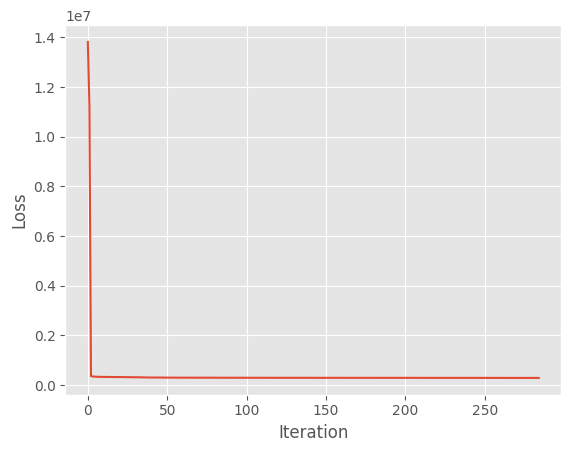

In [12]:
model = CustomProphet()
model.fit(df)

# Plot the loss over iterations
plt.plot(model.loss_over_iterations)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

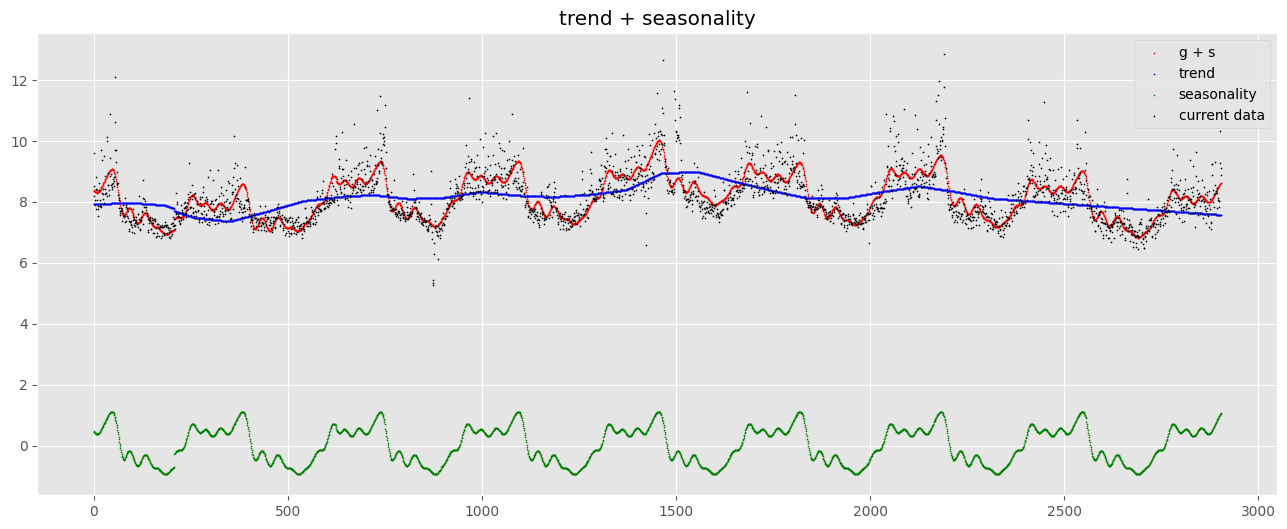

In [13]:
opt_params = model.get_parameters()
k, m, delta, beta = extract_params(opt_params)

# trend component
A = (model.t_scaled[:, None] > model.change_points) * 1
gamma = -model.change_points * delta
g = ((k + np.dot(A, delta)) * model.t_scaled + (m + np.dot(A, gamma))) * model.y_absmax
#g = ((k + det_dot(A, delta)) * model.t_scaled + (m + det_dot(A, gamma))) * model.y_absmax

x = fourier_components(model.t_scaled, 365.25 / model.scale_period, 10)
s = det_dot(x, beta) * model.y_absmax

plt.figure(figsize=(16, 6))
plt.title('trend + seasonality')
plt.scatter(np.arange(df.shape[0]), g+s, s=0.5, label='g + s', color='red')
plt.scatter(np.arange(df.shape[0]), g, s=0.5, label='trend', color='blue')
plt.scatter(np.arange(df.shape[0]), s, s=0.5, label='seasonality', color='green')
plt.scatter(np.arange(df.shape[0]), model.y, s=0.5, label='current data', color='black')
plt.legend()
plt.show()

In [14]:
model.opt, delta

(  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
   success: False
    status: 1
       fun: 287400.88683663687
         x: [ 1.420e-01  6.165e-01 ...  4.793e-04 -5.905e-03]
       nit: 285
       jac: [-8.232e+03 -1.138e+04 ... -7.124e+02  2.626e+03]
      nfev: 15024
      njev: 313
  hess_inv: <47x47 LbfgsInvHessProduct with dtype=float64>,
 array([-0.35627289, -0.76055686,  0.65622939,  1.11165998,  0.05498886,
        -0.52154936, -0.16591211, -0.47259611,  0.39271126,  0.39137519,
        -0.75477422,  0.15464716,  0.32354427,  0.16948891,  0.99394272,
        -1.29132471, -0.82996633,  0.04375713,  0.09373512,  0.6578317 ,
         0.47228432, -0.0703522 , -0.86633557, -0.11052393,  0.33202875]))

## Analytic Gradient Peyton Manning

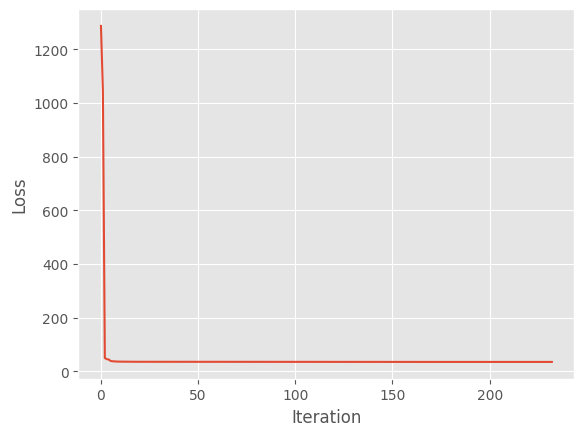

In [2]:
model = CustomProphet()
model.fit(df, analytic=True)

# Plot the loss over iterations
plt.plot(model.loss_over_iterations)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

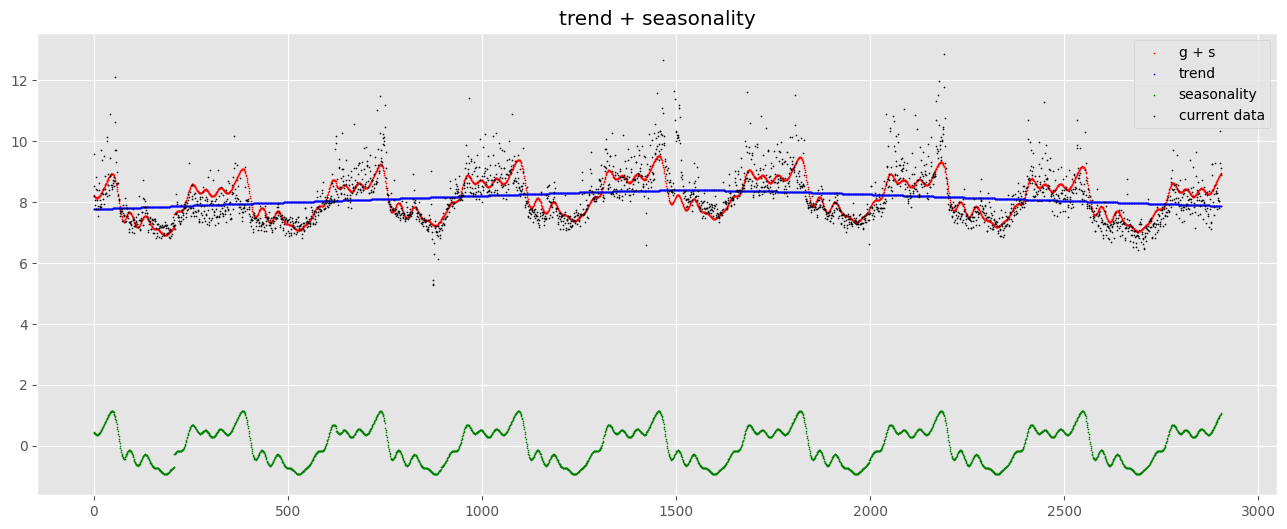

In [3]:
opt_params = model.get_parameters()
k, m, delta, beta = extract_params(opt_params)

# trend component
A = (model.t_scaled[:, None] > model.change_points) * 1
gamma = -model.change_points * delta
g = ((k + det_dot(A, delta)) * model.t_scaled + (m + det_dot(A, gamma))) * model.y_absmax

x = fourier_components(model.t_scaled, 365.25 / model.scale_period, 10)
s = det_dot(x, beta) * model.y_absmax

plt.figure(figsize=(16, 6))
plt.title('trend + seasonality')
plt.scatter(np.arange(df.shape[0]), g+s, s=0.5, label='g + s', color='red')
plt.scatter(np.arange(df.shape[0]), g, s=0.5, label='trend', color='blue')
plt.scatter(np.arange(df.shape[0]), s, s=0.5, label='seasonality', color='green')
plt.scatter(np.arange(df.shape[0]), model.y, s=0.5, label='current data', color='black')
plt.legend()
plt.show()

In [4]:
model.opt, delta

(  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
   success: True
    status: 0
       fun: 35.237670243587935
         x: [ 9.673e-02  6.046e-01 ...  4.823e-04 -5.797e-03]
       nit: 233
       jac: [-2.565e+00 -3.575e+00 ... -5.977e-03  1.759e-02]
      nfev: 368
      njev: 368
  hess_inv: <47x47 LbfgsInvHessProduct with dtype=float64>,
 array([ 7.74922712e-10, -1.38902184e-09,  1.40260456e-09, -1.79471988e-09,
         9.58023971e-11, -8.73978597e-10,  4.54744941e-09,  2.82245036e-10,
        -1.83556880e-09,  7.64770856e-09,  7.85565413e-10, -8.97288409e-08,
        -2.21880566e-07, -1.48143726e-02, -2.78247608e-02, -3.97695245e-02,
        -4.10189170e-02, -3.43737357e-02, -2.36627699e-02, -1.06700790e-02,
        -1.27968618e-09, -2.83564680e-09, -1.88020048e-09,  4.36893883e-09,
        -1.31861955e-09]))

## Objective + Gradient Combined Peyton Manning

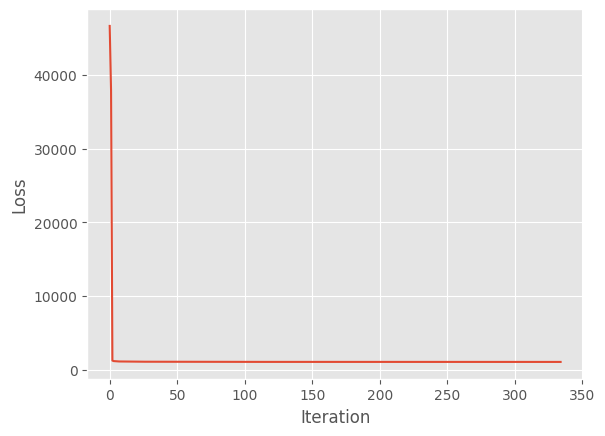

In [2]:
model = CustomProphet()
model.fit(df, use_combined=True)

# Plot the loss over iterations
plt.plot(model.loss_over_iterations)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

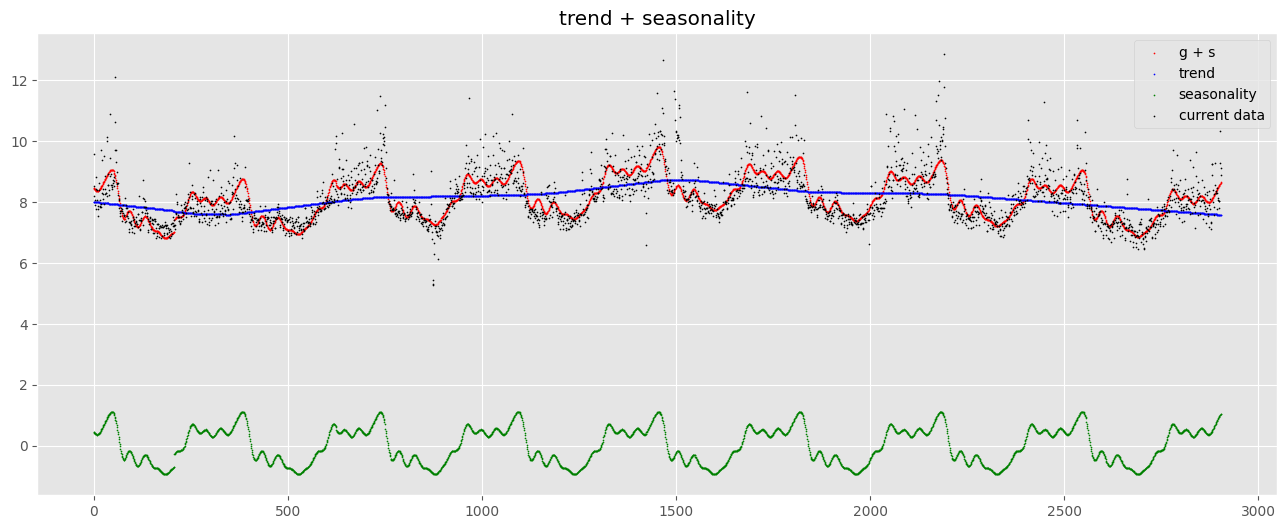

In [3]:
opt_params = model.get_parameters()
k, m, delta, beta = extract_params(opt_params)

# trend component
A = (model.t_scaled[:, None] > model.change_points) * 1
gamma = -model.change_points * delta
g = ((k + np.dot(A, delta)) * model.t_scaled + (m + np.dot(A, gamma))) * model.y_absmax
#g = ((k + det_dot(A, delta)) * model.t_scaled + (m + det_dot(A, gamma))) * model.y_absmax

x = fourier_components(model.t_scaled, 365.25 / model.scale_period, 10)
s = det_dot(x, beta) * model.y_absmax

plt.figure(figsize=(16, 6))
plt.title('trend + seasonality')
plt.scatter(np.arange(df.shape[0]), g+s, s=0.5, label='g + s', color='red')
plt.scatter(np.arange(df.shape[0]), g, s=0.5, label='trend', color='blue')
plt.scatter(np.arange(df.shape[0]), s, s=0.5, label='seasonality', color='green')
plt.scatter(np.arange(df.shape[0]), model.y, s=0.5, label='current data', color='black')
plt.legend()
plt.show()

In [4]:
model.opt, delta

(  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
   success: True
    status: 0
       fun: 1064.4670693307805
         x: [-3.081e-01  6.230e-01 ...  3.859e-04 -5.967e-03]
       nit: 335
       jac: [ 2.635e+01  5.082e+01 ...  2.272e+00 -3.502e-01]
      nfev: 483
      njev: 483
  hess_inv: <47x47 LbfgsInvHessProduct with dtype=float64>,
 array([ 5.93283402e-05, -4.85470752e-05,  2.19185440e-01,  4.56404780e-01,
        -8.79239447e-05, -2.09316083e-04, -9.98753050e-02, -2.19090180e-01,
        -2.55966287e-05,  3.73046165e-05,  1.81542525e-04,  1.10852316e-01,
         1.78355228e-01,  2.57014947e-03, -4.71015395e-09, -3.55261872e-01,
        -2.82301661e-01,  7.85890793e-05,  2.28345598e-05,  2.19855125e-01,
         4.82178609e-02,  3.18297920e-04, -8.40549558e-02, -1.07340840e-01,
        -9.50446301e-11]))

## Fitting Time

In [ ]:
%%timeit -r 10 -n 10

# Finite differences
model = CustomProphet()
model.fit(df)

In [1]:
%%timeit -r 10 -n 10

# Analytic
model = CustomProphet()
model.fit(df, analytic=True)

NameError: name 'CustomProphet' is not defined

In [14]:
%%timeit -r 10 -n 10

# Combined
model = CustomProphet()
model.fit(df, use_combined=True)

1.72 s ± 523 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [5]:
%%timeit -r 10 -n 10

# Combined
model = CustomProphet()
model.fit(df, use_combined=True)

The slowest run took 4.85 times longer than the fastest. This could mean that an intermediate result is being cached.
1.89 s ± 923 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [ ]:
%%timeit -r 10 -n 10

# Prophet
model = Prophet(weekly_seasonality=False, yearly_seasonality=True, daily_seasonality=False)
model.fit(df)

In [11]:
model.change_points

array([0.032, 0.064, 0.096, 0.128, 0.16 , 0.192, 0.224, 0.256, 0.288,
       0.32 , 0.352, 0.384, 0.416, 0.448, 0.48 , 0.512, 0.544, 0.576,
       0.608, 0.64 , 0.672, 0.704, 0.736, 0.768, 0.8  ])

## Memory Tracking

In [ ]:
# Finite differences
def prophetFit():
    model = CustomProphet()
    model.fit(df)

average_memory_usage, std = run_function_and_get_memory(prophetFit, num_runs=30, sleep_time=1)
if average_memory_usage:
    print(f"Average memory usage over 30 runs: {average_memory_usage / 1024**2} MB +/- {std / 1024**2} MB")
else:
    print("Failed to measure memory usage.")

In [ ]:
# Analytic
def prophetFit():
    model = CustomProphet()
    model.fit(df, analytic=True)
    
average_memory_usage, std = run_function_and_get_memory(prophetFit, num_runs=100, sleep_time=1)
if average_memory_usage:
    print(f"Average memory usage over 100 runs: {average_memory_usage / 1024**2} MB +/- {std / 1024**2} MB")
else:
    print("Failed to measure memory usage.")

In [ ]:
# Combined
def prophetFit():
    model = CustomProphet()
    model.fit(df, use_combined=True)
    
average_memory_usage, std = run_function_and_get_memory(prophetFit, num_runs=100, sleep_time=1)
if average_memory_usage:
    print(f"Average memory usage over 100 runs: {average_memory_usage / 1024**2} MB +/- {std / 1024**2} MB")
else:
    print("Failed to measure memory usage.")

In [ ]:
# Prophet
def prophetFit():
    model = Prophet(weekly_seasonality=False, yearly_seasonality=True, daily_seasonality=False)
    model.fit(df)

# Example usage:
average_memory_usage, std = run_function_and_get_memory(prophetFit, num_runs=100, sleep_time=1)
if average_memory_usage:
    print(f"Average memory usage over 30 runs: {average_memory_usage / 1024**2} MB +/- {std / 1024**2} MB")
else:
    print("Failed to measure memory usage.")

## Model Plot

In [ ]:
opt_params = model.get_parameters()
k, m, delta, beta = extract_params(opt_params)

# trend component
A = (model.t_scaled[:, None] > model.change_points) * 1
gamma = -model.change_points * delta
g = ((k + np.dot(A, delta)) * model.t_scaled + (m + np.dot(A, gamma))) * model.y_absmax
#g = ((k + det_dot(A, delta)) * model.t_scaled + (m + det_dot(A, gamma))) * model.y_absmax

x = fourier_components(model.t_scaled, 365.25 / model.scale_period, 10)
s = det_dot(x, beta) * model.y_absmax

plt.figure(figsize=(16, 6))
plt.title('trend + seasonality')
plt.scatter(np.arange(df.shape[0]), g+s, s=0.5, label='g + s', color='red')
plt.scatter(np.arange(df.shape[0]), g, s=0.5, label='trend', color='blue')
plt.scatter(np.arange(df.shape[0]), s, s=0.5, label='seasonality', color='green')
plt.scatter(np.arange(df.shape[0]), model.y, s=0.5, label='current data', color='black')
plt.legend()
plt.show()

In [ ]:
delta

In [ ]:
opt_params = model.get_parameters()
k, m, delta, beta = extract_params(opt_params)

# trend component
A = (model.t_scaled[:, None] > model.change_points) * 1
gamma = -model.change_points * delta
g = ((k + det_dot(A, delta)) * model.t_scaled + (m + det_dot(A, gamma))) * model.y_absmax

x = fourier_components(model.t_scaled, 365.25 / model.scale_period, 10)
s = det_dot(x, beta) * model.y_absmax

plt.figure(figsize=(16, 6))
plt.title('trend + seasonality')
plt.scatter(np.arange(df.shape[0]), g+s, s=0.5, label='g + s', color='red')
plt.scatter(np.arange(df.shape[0]), g, s=0.5, label='trend', color='blue')
plt.scatter(np.arange(df.shape[0]), s, s=0.5, label='seasonality', color='green')
plt.scatter(np.arange(df.shape[0]), model.y, s=0.5, label='current data', color='black')
plt.legend()
plt.show()

In [ ]:
opt_params = model.get_parameters()
k, m, delta, beta = extract_params(opt_params)

# trend component
A = (model.t_scaled[:, None] > model.change_points) * 1
gamma = -model.change_points * delta
g = ((k + det_dot(A, delta)) * model.t_scaled + (m + det_dot(A, gamma))) * model.y_absmax

x = fourier_components(model.t_scaled, 365.25 / model.scale_period, 10)
s = det_dot(x, beta) * model.y_absmax

plt.figure(figsize=(16, 6))
plt.title('trend + seasonality')
plt.scatter(np.arange(df.shape[0]), g+s, s=0.5, label='g + s', color='red')
plt.scatter(np.arange(df.shape[0]), g, s=0.5, label='trend', color='blue')
plt.scatter(np.arange(df.shape[0]), s, s=0.5, label='seasonality', color='green')
plt.scatter(np.arange(df.shape[0]), model.y, s=0.5, label='current data', color='black')
plt.legend()
plt.show()

In [ ]:
delta

In [ ]:
opt_params = model.get_parameters()
k, m, delta, beta = extract_params(opt_params)

# trend component
A = (model.t_scaled[:, None] > model.change_points) * 1
gamma = -model.change_points * delta
g = ((k + det_dot(A, delta)) * model.t_scaled + (m + det_dot(A, gamma))) * model.y_absmax

x = fourier_components(model.t_scaled, 365.25 / model.scale_period, 10)
s = det_dot(x, beta) * model.y_absmax

plt.figure(figsize=(16, 6))
plt.title('trend + seasonality')
plt.scatter(np.arange(df.shape[0]), g+s, s=0.5, label='g + s', color='red')
plt.scatter(np.arange(df.shape[0]), g, s=0.5, label='trend', color='blue')
plt.scatter(np.arange(df.shape[0]), s, s=0.5, label='seasonality', color='green')
plt.scatter(np.arange(df.shape[0]), model.y, s=0.5, label='current data', color='black')
plt.legend()
plt.show()

***
## VoLTE_ATT

In [ ]:
df = pd.read_csv('sample_data_2.csv')

CHANNEL = 84058 # channel to forecast

START_DATE = '2021/07/01 0:00'
END_DATE = '2021/07/07 23:00'

df['START_TIME'] = pd.to_datetime(df['START_TIME'], format='%Y/%m/%d %H:%M')

df.ffill(inplace=True) # fill missing values with previous values
df = df[df['eNodeB_ID'] == CHANNEL] # filter by eNodeB_ID=84058

# filter by date range
start_date = pd.to_datetime(START_DATE)
end_date = pd.to_datetime(END_DATE)
df = df[(df['START_TIME'] >= start_date) & (df['START_TIME'] <= end_date)]
df = df.loc[:, ['START_TIME', 'VoLTE_ATT']]

# create new columns 't' and 'y_scaled'
df['t'] = (df['START_TIME'] - df['START_TIME'].min()) / (df['START_TIME'].max() - df['START_TIME'].min())
df['y_scaled'] = df['VoLTE_ATT'] / df['VoLTE_ATT'].max()
df.rename(columns={'START_TIME': 'ds', 'VoLTE_ATT': 'y'}, inplace=True)

model = CustomProphet()
model.fit(df)

# Plot the loss over iterations
plt.plot(model.loss_over_iterations)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [ ]:
opt_params = model.get_parameters()
k, m, delta, beta = extract_params(opt_params)

# trend component
A = (model.t_scaled[:, None] > np.array(model.change_points)) * 1
gamma = -model.change_points * delta
g = (k + det_dot(A, delta)) * model.t_scaled + (m + det_dot(A, gamma)) * model.y_absmax

x = fourier_components(model.t_scaled, 365.25 / model.scale_period, 10)
s = det_dot(x, beta) * model.y_absmax

plt.figure(figsize=(16, 6))
plt.title('trend + seasonality')
plt.scatter(np.arange(df.shape[0]), g+s, s=0.5, label='g + s', color='red')
plt.scatter(np.arange(df.shape[0]), model.y, s=0.5, label='current data', color='black')
plt.legend()
plt.show()